# Settings

## Libraries

In [1]:
import pandas as pd
import nltk
import unidecode

from string import punctuation  # all punctuation

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

## Datasets

In [3]:
df = pd.read_csv('imdb-reviews.csv')

## Methods

In [5]:
def removing_irrelevant_data(text, stop_words):
    
    # spliting text and removing punctuation
    punctuation_remover = nltk.tokenize.WordPunctTokenizer()
    text = punctuation_remover.tokenize(text)
    phrase = ''
    
    # removing stopwords
    for word in text:
        if word not in stop_words:
            phrase += f' {word}'        
    
    return phrase

# Model

In [6]:
# removing accents
df['text_cleaned'] = df.text_pt.apply(lambda x: unidecode.unidecode(x))

In [7]:
# removing stop words and punctuation
list_punctuation = [x for x in punctuation]
stop_words = nltk.corpus.stopwords.words('portuguese')
irrelevant_data = list_punctuation + stop_words

# As the accents were removed from the text, It should be done in the list of irrelevant too
irrelevant_data = [unidecode.unidecode(x) for x in irrelevant_data] 

# removing
df['text_cleaned'] = df.text_cleaned.apply(removing_irrelevant_data, stop_words=irrelevant_data)

In [8]:
df.sentiment = df.sentiment.replace({'pos':1, 'neg':0})

In [9]:
vectorizer = CountVectorizer(max_features=100)  # it will select the n words that most appear
bag_of_words = vectorizer.fit_transform(df.text_cleaned)  # when vetorizing, the machine auto apply a lower function
columns = vectorizer.get_feature_names_out()

bag_of_words = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=columns)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, df.sentiment, test_size=0.25)

In [11]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

LogisticRegression()

In [12]:
lr_model.score(x_train, y_train)

0.7155065509246779

# Analysis

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [14]:
def generate_wc(df: pd.DataFrame, col: str, condition: str = None) -> None:
    if condition:
        df = df.query(condition)

    list_phrases = df[col].to_list()
    unique_string = ' '.join(list_phrases)

    wc = WordCloud(width=800, height=500, collocations=False,
                   max_font_size=100)
    wc = wc.generate(unique_string)

    plt.figure(figsize=(15, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()


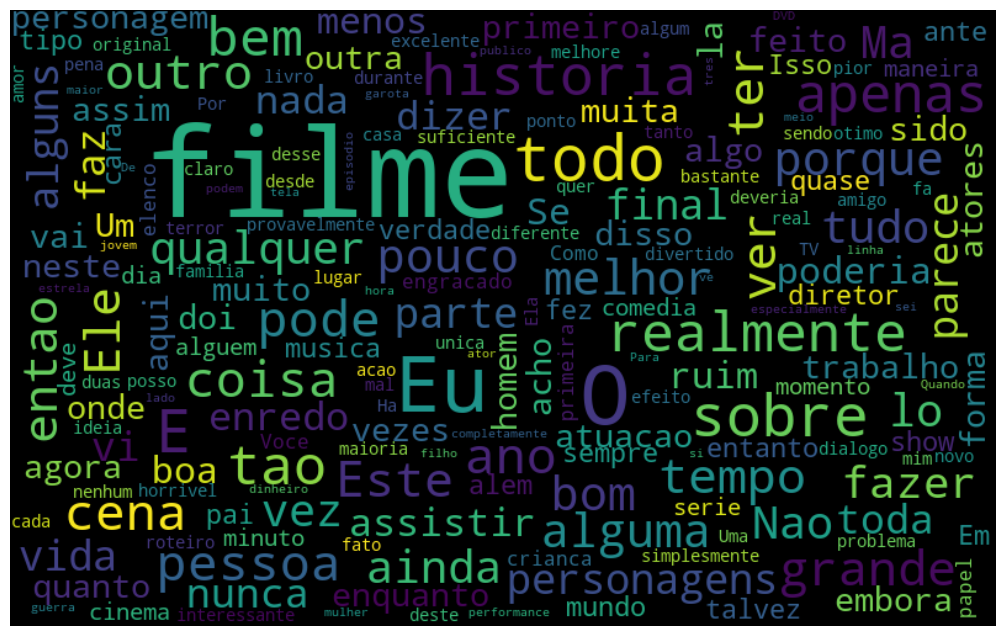

In [15]:
generate_wc(df, 'text_cleaned')

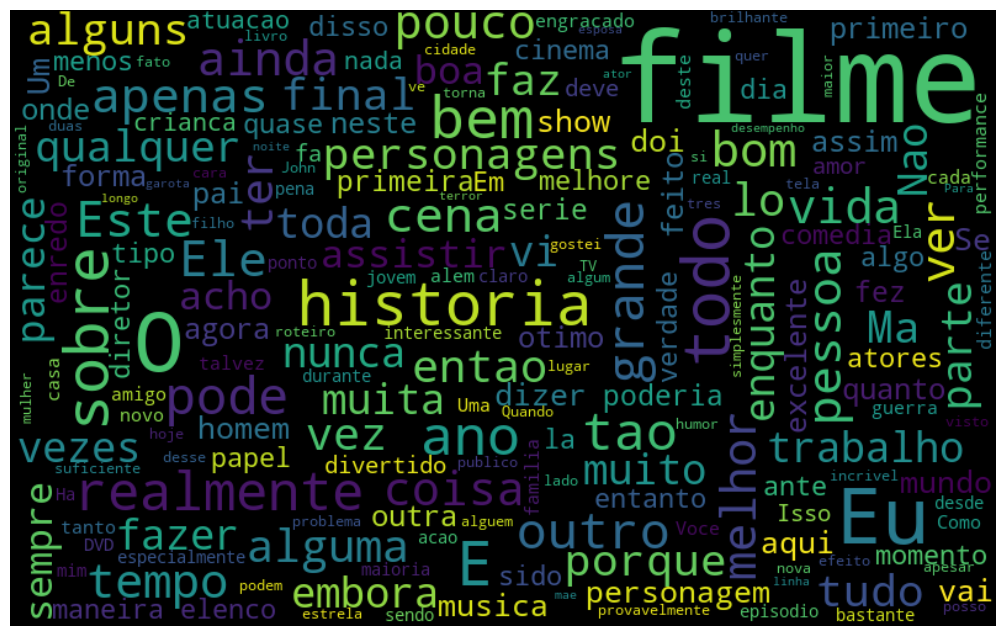

In [16]:
generate_wc(df, 'text_cleaned', "sentiment == 1")

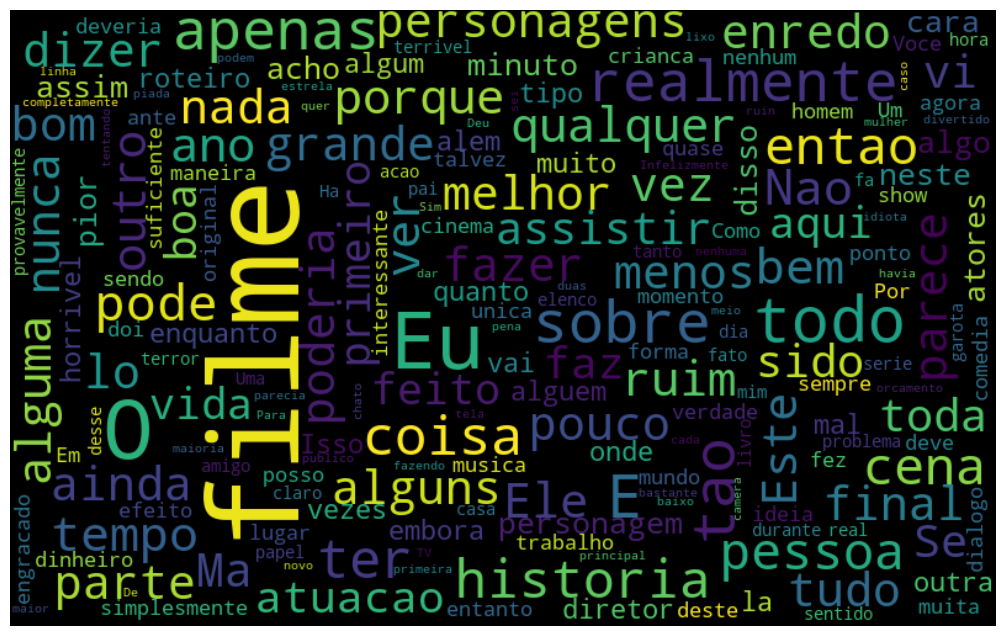

In [17]:
generate_wc(df, 'text_cleaned', "sentiment == 0")

In [18]:
import seaborn as sns

unique_str = ''
for _, phrase in df.text_cleaned.items():
    unique_str += f' {phrase}'
    
token_creator = nltk.tokenize.WhitespaceTokenizer()
tokens = token_creator.tokenize(unique_str)

freq_tokens = nltk.FreqDist(tokens)
df_freq_tokens = pd.DataFrame({'word':freq_tokens.keys(), 'freq':freq_tokens.values()})

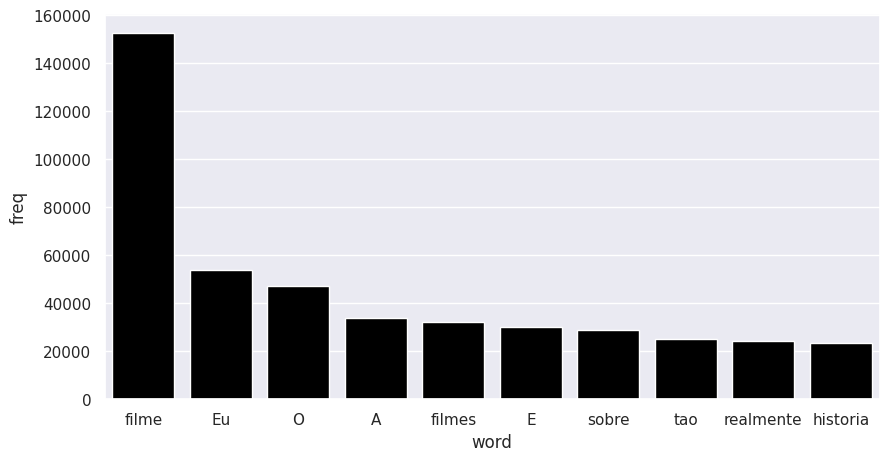

In [46]:
# adjusting graph size 
sns.set(rc={'figure.figsize':(10,5)})

most_appear = df_freq_tokens.nlargest(n=10, columns='freq')
most_freq_graph = sns.barplot(data=most_appear, x='word', y='freq', color='black')
plt.show()

*How does any relation is established between bag_of_words and the column "sentiment"?*

In [20]:
# These two objects are differents dataframes, so probably it's based on the index 
# Considering this, I'll change one these Df to see if any change happens with the model

new_target = df.sentiment[::-1]
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, new_target, test_size=0.25)

new_lr_model = LogisticRegression().fit(x_train, y_train)
new_lr_model.score(x_test, y_test)

0.7101496158511929

In [21]:
# as the model target distribution is 50-50, with all neg's in the beggining
# reversing the order of the target wont causa any relevant impact, its like if a just changed the label. 
# so I'll try to randomize to let it confuse and prove the initial hypothesis

from random import randint

target = [randint(0, 1) for _ in range(100)]
target = pd.Series(target)

x_train, x_test, y_train, y_test = train_test_split(bag_of_words, new_target, test_size=0.25)
new_lr_model = LogisticRegression().fit(x_train, y_train)
new_lr_model.score(x_test, y_test)

0.7123331985442782

In [22]:
# Bag of Words is so bad, that the results dont let me validated 
# my doubt and beside this, it possible to conclude by the 
# previous results how vague it's. 

# Conclusion

- A lot of stop words yet --> upper case is impeding to remove all of them  
- There a lot of similar words being considered as differents, like "filme" and "filmes"  

Next Version --> Apply stemming and remove these stop words